In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('heat_transfer_multilayer_dataset.csv')

In [4]:
material_columns = ['Mat1', 'Mat2', 'Mat3', 'Mat4', 'Mat5']
label_encoders = {}
for col in material_columns:
    df[col] = df[col].fillna('None')
    le = LabelEncoder()
    df[f'{col}_enc'] = le.fit_transform(df[col])
    label_encoders[col] = le

In [5]:
feature_columns = ['delta_T', 'L1', 'k1', 'L2', 'k2', 'L3', 'k3', 'L4', 'k4', 'L5', 'k5'] + [f'{col}_enc' for col in material_columns]
for col in feature_columns:
    df[col] = df[col].fillna(0)
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[feature_columns] = scaler.fit_transform(df[feature_columns])


In [6]:
X = df_scaled[feature_columns]
y = df_scaled['Q']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 800 samples
Testing set: 200 samples


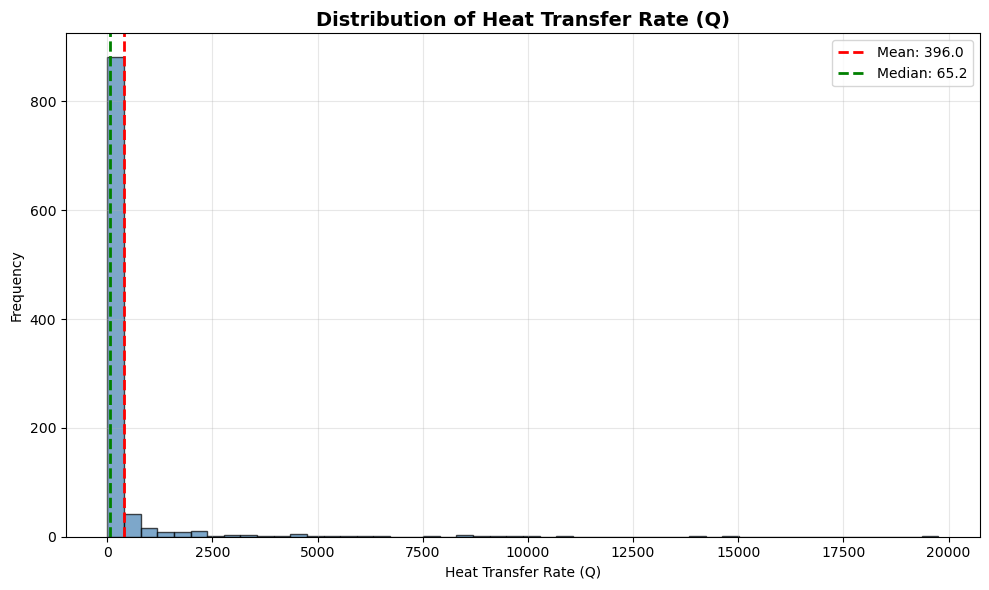

In [7]:
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.hist(df['Q'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_title('Distribution of Heat Transfer Rate (Q)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Heat Transfer Rate (Q)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)
q_mean = df['Q'].mean()
q_median = df['Q'].median()
ax1.axvline(q_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {q_mean:.1f}')
ax1.axvline(q_median, color='green', linestyle='--', linewidth=2, label=f'Median: {q_median:.1f}')
ax1.legend()
plt.tight_layout()
plt.show()



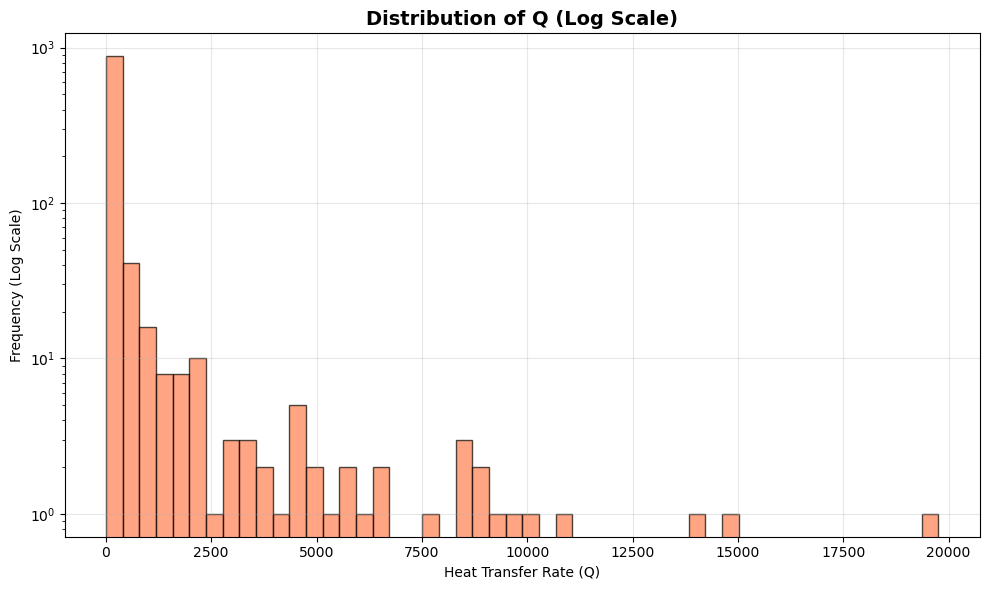

In [8]:
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.hist(df['Q'], bins=50, edgecolor='black', alpha=0.7, color='coral')
ax2.set_yscale('log')
ax2.set_title('Distribution of Q (Log Scale)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Heat Transfer Rate (Q)')
ax2.set_ylabel('Frequency (Log Scale)')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


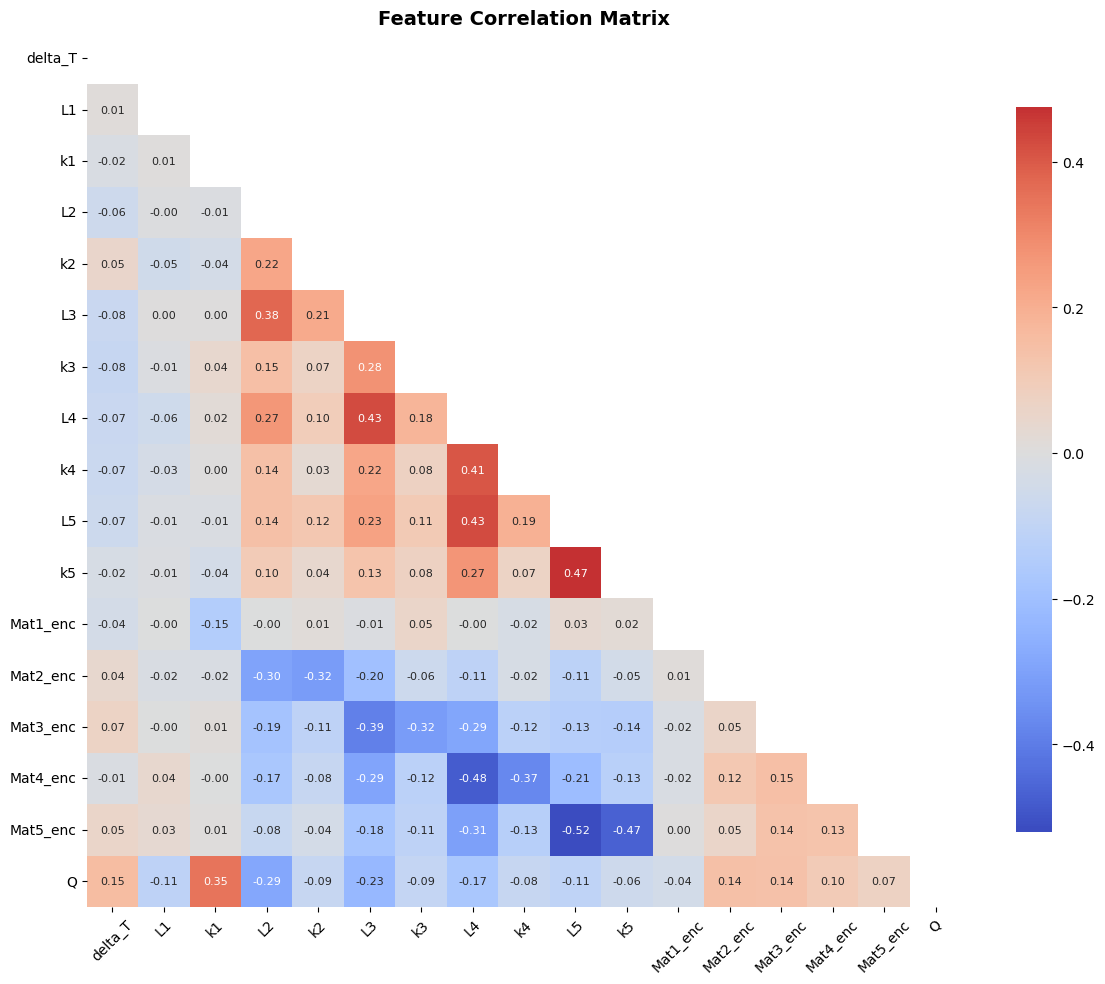

In [9]:
fig3, ax3 = plt.subplots(figsize=(12, 10))
correlation_data = df_scaled[feature_columns + ['Q']].corr()
mask = np.triu(np.ones_like(correlation_data, dtype=bool))  
sns.heatmap(correlation_data, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            ax=ax3,
            cbar_kws={"shrink": .8},
            annot_kws={'size': 8})
ax3.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.tick_params(axis='y', rotation=0)
plt.tight_layout()
plt.show()

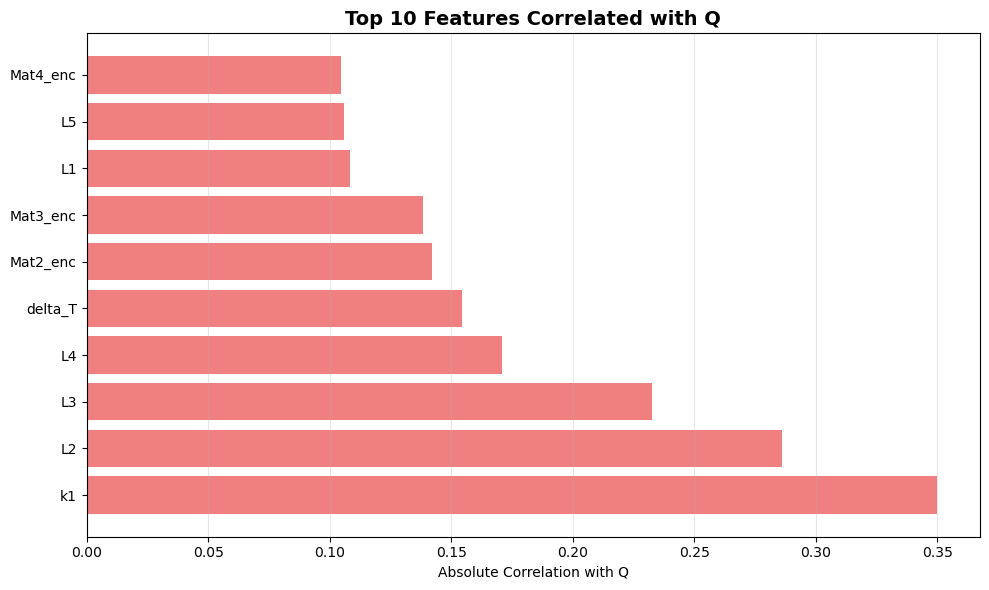

In [10]:
fig4, ax4 = plt.subplots(figsize=(10, 6))
q_correlations = correlation_data['Q'].abs().sort_values(ascending=False)[1:]  
top_features = q_correlations.head(10)
ax4.barh(range(len(top_features)), top_features.values, color='lightcoral')
ax4.set_yticks(range(len(top_features)))
ax4.set_yticklabels(top_features.index)
ax4.set_xlabel('Absolute Correlation with Q')
ax4.set_title('Top 10 Features Correlated with Q', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [11]:
print(f"\nDataset Summary:")
print(f"Total samples: {len(df):,}")
print(f"Features: {len(feature_columns)}")
print(f"\nQ Statistics:")
print(f"Min: {df['Q'].min():.2f}")
print(f"Max: {df['Q'].max():.2f}")
print(f"Mean: {df['Q'].mean():.2f}")
print(f"Median: {df['Q'].median():.2f}")
print(f"Std: {df['Q'].std():.2f}")
print(f"Skewness: {df['Q'].skew():.2f}")

print(f"\nTop 5 features most correlated with Q:")
for feature, corr in q_correlations.head(5).items():
    print(f"{feature}: {corr:.3f}")


Dataset Summary:
Total samples: 1,000
Features: 16

Q Statistics:
Min: 7.47
Max: 19758.04
Mean: 395.98
Median: 65.15
Std: 1445.47
Skewness: 7.14

Top 5 features most correlated with Q:
k1: 0.350
L2: 0.286
L3: 0.233
L4: 0.171
delta_T: 0.154


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb


In [13]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, verbosity=0),
    'Neural Network (MLP)': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

In [14]:
trained_models = {}
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    trained_models[name] = model
    predictions[name] = {
        'train_pred': y_pred_train,
        'test_pred': y_pred_test
    }
    